# Imports

In [1]:
import numpy as np

from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU
from torch.nn.functional import softmax, relu

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#use_cuda = torch.cuda.is_available()
use_cuda = False
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

# Torchtext dataloader 

In [99]:
#Initialize the two fields: Sequence and Class
SEQ = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?

#Load the data
train_set, validation_set, test_set = data.TabularDataset.splits(path='./data/',
                                                                 train='train_filtered.txt',
                                                                 validation='val_filtered.txt',
                                                                 test='test_filtered.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

(array([4.681e+03, 5.664e+03, 2.603e+03, 9.560e+02, 4.280e+02, 1.480e+02,
        7.500e+01, 4.300e+01, 9.000e+00, 4.000e+00]),
 array([  123.,  2044.,  3965.,  5886.,  7807.,  9728., 11649., 13570.,
        15491., 17412., 19333.]),
 <a list of 10 Patch objects>)

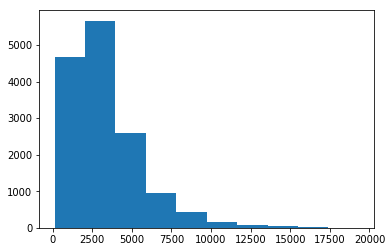

In [100]:
L = [len(train_set[i].sequence) for i in range(len(train_set))]
plt.hist(L)


In [101]:
print('train_set.fields:', list(train_set.fields.keys()))
print('validation_set.fields:', list(validation_set.fields.keys()))
print('test_set.fields:', list(test_set.fields.keys()))
print()
print('size of training set', len(train_set))
print('size of validation set', len(validation_set))
print()
print('content of first training sample:')
print(vars(train_set[0]))

train_set.fields: ['sequence', 'label']
validation_set.fields: ['sequence', 'label']
test_set.fields: ['sequence', 'label']

size of training set 14611
size of validation set 2084

content of first training sample:
{'sequence': ['T', 'G', 'G', 'G', 'C', 'T', 'C', 'C', 'C', 'G', 'C', 'C', 'T', 'C', 'A', 'G', 'T', 'G', 'C', 'G', 'C', 'A', 'T', 'G', 'T', 'T', 'C', 'A', 'C', 'T', 'G', 'G', 'G', 'C', 'G', 'T', 'C', 'T', 'T', 'C', 'T', 'G', 'C', 'C', 'C', 'G', 'G', 'C', 'C', 'C', 'C', 'T', 'T', 'C', 'G', 'C', 'C', 'C', 'A', 'C', 'G', 'T', 'G', 'A', 'A', 'G', 'A', 'A', 'C', 'G', 'C', 'C', 'A', 'G', 'G', 'G', 'A', 'G', 'C', 'T', 'G', 'T', 'G', 'A', 'G', 'G', 'C', 'A', 'G', 'T', 'G', 'C', 'T', 'G', 'T', 'G', 'T', 'G', 'G', 'T', 'T', 'C', 'C', 'T', 'G', 'C', 'C', 'G', 'T', 'C', 'C', 'G', 'G', 'A', 'C', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'C', 'C', 'T', 'C', 'T', 'A', 'C', 'T', 'G', 'A', 'G', 'A', 'T', 'T', 'C', 'A', 'T', 'C', 'T', 'G', 'T', 'G', 'T', 'G', 'A', 'A', 'A', 'T', 'A', 'T', 'G', 'A', '

In [102]:
# build the vocabularies
SEQ.build_vocab(train_set) #NO unknows 
LABEL.build_vocab(train_set)

In [103]:
print('Text fields:')
print(' size of vocabulary:', len(SEQ.vocab))
# print(" vocabulary's embedding dimension:", SEQ.vocab.vectors.size())
print(' no. times the "N" appear in the dataset:', SEQ.vocab.freqs['N'])
print(" list of vocabulary (int-to-str):", SEQ.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(SEQ.vocab.stoi))
print(SEQ.vocab.freqs)
print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))

Text fields:
 size of vocabulary: 6
 no. times the "N" appear in the dataset: 85
 list of vocabulary (int-to-str): ['N', '<pad>', 'A', 'T', 'G', 'C']
 list of vocabulary (str-to-int): {'N': 0, '<pad>': 1, 'A': 2, 'T': 3, 'G': 4, 'C': 5}
Counter({'A': 12942620, 'T': 12224600, 'G': 11901485, 'C': 11648150, 'N': 85})

Label fields:
 list of vocabulary (int-to-str): ['1', '0', '3', '4', '2', '5']
 list of vocabulary (str-to-int): {'1': 0, '0': 1, '3': 2, '4': 3, '2': 4, '5': 5}


In [104]:
LABEL.vocab.freqs

Counter({'3': 2874, '0': 3486, '1': 5531, '2': 814, '4': 1578, '5': 328})

In [105]:
# make iterator for splits
# train_iter, val_iter = data.BucketIterator.splits((train_set, validation_set),
#                                                      batch_size=128, 
#                                                      device=0 if use_cuda else -1,
#                                                      sort_key=lambda x: len(x.sequence), #Sorting within the batch
#                                                      sort_within_batch=False,
#                                                      repeat=False)

train_iter = data.BucketIterator(train_set,
                                 batch_size=128, 
                                 device=0 if use_cuda else -1,
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=128, 
                                 device=0 if use_cuda else -1,
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True
                                )


## Checking dynamical batching 

In [67]:
for i,batch in enumerate(validation_iter):
    print(min(batch.sequence[1]),max(batch.sequence[1]))
    if i==10 : 
        break
    

tensor(187) tensor(932)
tensor(933) tensor(1236)
tensor(1239) tensor(1541)
tensor(1543) tensor(1787)
tensor(1788) tensor(2008)
tensor(2010) tensor(2219)
tensor(2226) tensor(2467)
tensor(2468) tensor(2763)
tensor(2765) tensor(3074)
tensor(3074) tensor(3443)
tensor(3443) tensor(3799)


In [65]:
for i,batch in enumerate(train_iter):
    print(min(batch.sequence[1]),max(batch.sequence[1]))
    if i==10 : 
        break
    

tensor(123) tensor(511)
tensor(514) tensor(599)
tensor(601) tensor(677)
tensor(677) tensor(747)
tensor(747) tensor(816)
tensor(816) tensor(882)
tensor(882) tensor(930)
tensor(930) tensor(969)
tensor(969) tensor(1020)
tensor(1020) tensor(1072)
tensor(1072) tensor(1120)


In [74]:
# print batch information
batch = next(iter(train_iter))
print("dimension of batch's text:", batch.sequence)
print("first sequence in text:", batch.sequence[0][:,0])
print("correct label index:", batch.label[0])
print("the actual label:", LABEL.vocab.itos[get_numpy(batch.label[0])])

dimension of batch's text: (tensor([[4, 2, 4,  ..., 5, 2, 2],
        [4, 4, 3,  ..., 2, 5, 3],
        [5, 3, 2,  ..., 4, 2, 4],
        ...,
        [2, 2, 5,  ..., 1, 1, 1],
        [2, 2, 3,  ..., 1, 1, 1],
        [2, 2, 1,  ..., 1, 1, 1]]), tensor([511, 511, 510, 509, 508, 504, 504, 501, 497, 494, 493, 492, 492, 491,
        489, 488, 488, 486, 485, 484, 483, 483, 481, 481, 478, 478, 477, 477,
        476, 474, 473, 473, 469, 469, 467, 467, 465, 464, 462, 462, 461, 460,
        456, 453, 452, 450, 449, 447, 447, 446, 444, 443, 442, 441, 441, 439,
        438, 437, 437, 437, 434, 434, 433, 433, 432, 430, 427, 427, 420, 420,
        419, 417, 417, 417, 416, 414, 413, 412, 412, 411, 410, 409, 403, 402,
        397, 396, 393, 393, 387, 378, 377, 376, 374, 374, 372, 370, 370, 368,
        364, 360, 353, 351, 349, 348, 345, 342, 339, 335, 333, 332, 331, 328,
        322, 318, 315, 313, 307, 307, 303, 303, 292, 289, 288, 287, 287, 247,
        223, 123]))
first sequence in text: tensor(

In [81]:
print(batch.sequence[1])
mask = np.array([[1 if i<max_len else -10 for i in range(max(batch.sequence[1]))] for max_len in batch.sequence[1]])
print(mask)

tensor([511, 511, 510, 509, 508, 504, 504, 501, 497, 494, 493, 492, 492, 491,
        489, 488, 488, 486, 485, 484, 483, 483, 481, 481, 478, 478, 477, 477,
        476, 474, 473, 473, 469, 469, 467, 467, 465, 464, 462, 462, 461, 460,
        456, 453, 452, 450, 449, 447, 447, 446, 444, 443, 442, 441, 441, 439,
        438, 437, 437, 437, 434, 434, 433, 433, 432, 430, 427, 427, 420, 420,
        419, 417, 417, 417, 416, 414, 413, 412, 412, 411, 410, 409, 403, 402,
        397, 396, 393, 393, 387, 378, 377, 376, 374, 374, 372, 370, 370, 368,
        364, 360, 353, 351, 349, 348, 345, 342, 339, 335, 333, 332, 331, 328,
        322, 318, 315, 313, 307, 307, 303, 303, 292, 289, 288, 287, 287, 247,
        223, 123])
[[  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1 -10]
 ...
 [  1   1   1 ... -10 -10 -10]
 [  1   1   1 ... -10 -10 -10]
 [  1   1   1 ... -10 -10 -10]]


In [ ]:
# size of embeddings
embedding_dim = SEQ.vocab.vectors.size()[1]
num_embeddings = SEQ.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden = self.init_hidden()
        
        #learn a new embedding
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        # use pretrained embeddings
        
        self.lstm = LSTM(input_size=embedding_dim,
                         hidden_size=100,
                         num_layers=1,
                         bidirectional=False)
        
        self.l_out = Linear(in_features=200,
                            out_features=num_classes,
                            bias=False)
        
    def forward(self, x):
        out = {}
        
        # get embeddings
        x = self.embeddings(x)
        
        x = nn.utils.rnn.pack_padded_sequence(x, batch_first=True)
        
        # rnn returns output and last hidden state
        x, hn = self.lstm(x, self.hidden)
        
        # get a fixed sized hidden representation of the entire sequence
        out['hidden'] = x = torch.cat((torch.mean(x, dim=0), torch.max(x, dim=0)[0]), dim=1)
        
        # classify
        out['out'] = softmax(self.l_out(x), dim=1)
        return out

net = Net()
if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

In [ ]:
# check which params require grad
{p[0]: p[1].requires_grad for p in net.named_parameters()}

In [ ]:
criterion = nn.CrossEntropyLoss()
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

def construct_sentences(batch):
    return [" ".join([SEQ.vocab.itos[elm] 
                      for elm in get_numpy(batch.sequence[:,i])])
            for i in range(batch.sequence.size()[1])]

def get_labels(batch):
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

In [ ]:
max_iter = 25000
eval_every = 1000
log_every = 500

train_loss, train_accs = [], []

net.train()
for i, batch in enumerate(train_iter):
        batch = batch[0]
    if i % eval_every == 0:
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
        for val_batch in val_iter:
            output = net(val_batch.sequence)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
            val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
            val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
            val_lengths += val_batch.batch_size
            
            for key, _val in output.items():
                if key not in val_meta:
                    val_meta[key] = []
                val_meta[key].append(get_numpy(_val)) 
            val_meta['label_idx'].append(get_numpy(val_batch.label))
            val_meta['sentences'].append(construct_sentences(val_batch))
            val_meta['labels'].append(get_labels(val_batch))
        
        for key, _val in val_meta.items():
            val_meta[key] = np.concatenate(_val)
        
        # divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        
        print("### EVAL loss: {:.2f} accs: {:.2f}".format(get_numpy(val_losses),
                                                          get_numpy(val_accs)))
        net.eval()

        
    output = net(batch.text)
    batch_loss = criterion(output['out'], batch.label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    if i % log_every == 0:        
        print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
        train_loss, train_accs = [], []
        
    
    if max_iter < i:
        break